# Notebook 05: Tumour Growth Rate Prediction

This notebook predicts **tumour growth rate** (mm³/day) between consecutive MRI timepoints using baseline clinical features and first-timepoint imaging features.

This addresses Aim 2 of the project: *"Create predictive models that forecast tumour evolution trajectories (growth rates, patterns, morphological changes)."*

**Task:** Regression (continuous target), not classification.

**Input:** Clinical + molecular features (available at diagnosis) + first-timepoint imaging statistics from the pre-computed segmentation volumes.

**Target:** Growth rate = (Volume_t1 - Volume_t0) / days_elapsed, in mm³/day.

**Sample:** ~82 patients with at least 2 imaging timepoints.

## Setup

In [142]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('colorblind')

In [143]:
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor
from scipy import stats

In [144]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

from google.colab import userdata
GLIOMA_DIR = userdata.get('GLIOMA_DIR')
print(f"Glioma directory: {GLIOMA_DIR}")

Mounted at /content/drive/
Glioma directory: drive/MyDrive/Y3 Project/Data/PKG_MU_Glioma_Post


In [145]:
results_dir = os.path.join(GLIOMA_DIR, 'results', 'growth_rate')
figures_dir = os.path.join(GLIOMA_DIR, 'results', 'figures', 'growth_rate')
os.makedirs(results_dir, exist_ok=True)
os.makedirs(figures_dir, exist_ok=True)
print(f"Results directory: {results_dir}")
print(f"Figures directory: {figures_dir}")

Results directory: drive/MyDrive/Y3 Project/Data/PKG_MU_Glioma_Post/results/growth_rate
Figures directory: drive/MyDrive/Y3 Project/Data/PKG_MU_Glioma_Post/results/figures/growth_rate


## Load Data

We need two data sources:
1. **Clinical data** (preprocessed from Notebook 01): demographics, molecular markers, tumour characteristics.
2. **Segmentation volumes** (pre-computed by dataset providers): tumour volume and intensity statistics per timepoint.

### Load Clinical Data

In [146]:
preprocessed_dir = os.path.join(GLIOMA_DIR, 'preprocessed')

high_fill_df = pd.read_pickle(os.path.join(preprocessed_dir, 'high_fill_df.pkl'))
X = pd.read_pickle(os.path.join(preprocessed_dir, 'X.pkl'))
y = pd.read_pickle(os.path.join(preprocessed_dir, 'y.pkl'))

print(f"Clinical data loaded: {high_fill_df.shape}")
print(f"X: {X.shape}, y: {y.shape}")

Clinical data loaded: (203, 29)
X: (203, 28), y: (203,)


### Load Segmentation Volumes

In [147]:
seg_path = os.path.join(GLIOMA_DIR, 'MU_Glioma_Post_Segmentation_Volumes.xlsx')
seg_df = pd.read_excel(seg_path)

print(f"Segmentation data loaded: {seg_df.shape}")
print(f"Unique patients: {seg_df['Patient ID'].nunique()}")
print(f"\nColumns:")
for col in seg_df.columns:
    print(f"  - {col}")

Segmentation data loaded: (334, 13)
Unique patients: 173

Columns:
  - Patient ID
  - Label Id
  - Label Name
  - Number Of Voxels
  - Volume (mm^3)
  - Image mean (brain_t1c)
  - Image stdev (brain_t1c)
  - Image mean (brain_t1n)
  - Image stdev (brain_t1n)
  - Image mean (brain_t2f)
  - Image stdev (brain_t2f)
  - Image mean (brain_t2w)
  - Image stdev (brain_t2w)


## Construct Growth Rate Target

For each patient with at least 2 timepoints, we compute the growth rate between their first two scans.

**Formula:** `growth_rate = (volume_t1 - volume_t0) / days_elapsed`

Units: mm³/day. A positive value means the tumour grew; negative means it shrank (e.g. post-treatment response).

We use only the first pair of timepoints (t0 → t1) to keep the prediction task clean: predict growth from baseline.

In [148]:
# Sort by patient and timepoint order
seg_sorted = seg_df.sort_values(['Patient ID', 'Label Id']).reset_index(drop=True)

# Check how many timepoints each patient has
tp_counts = seg_sorted.groupby('Patient ID').size()
print(f"Patients with 1 timepoint: {(tp_counts == 1).sum()}")
print(f"Patients with 2+ timepoints: {(tp_counts >= 2).sum()}")
print(f"\nTimepoint distribution:")
print(tp_counts.value_counts().sort_index())

Patients with 1 timepoint: 91
Patients with 2+ timepoints: 82

Timepoint distribution:
1    91
2    46
3     9
4    16
5     6
6     5
Name: count, dtype: int64


### Extract First Two Timepoints Per Patient

We take the first and second rows for each patient in the segmentation data. These correspond to consecutive post-treatment MRI scans.

In [149]:
# Get patients with at least 2 timepoints
multi_tp_patients = tp_counts[tp_counts >= 2].index.tolist()
print(f"Patients with 2+ timepoints: {len(multi_tp_patients)}")

# Extract first two timepoints per patient
growth_records = []

for pid in multi_tp_patients:
    patient_rows = seg_sorted[seg_sorted['Patient ID'] == pid].iloc[:2]
    t0 = patient_rows.iloc[0]
    t1 = patient_rows.iloc[1]

    vol_t0 = t0['Volume (mm^3)']
    vol_t1 = t1['Volume (mm^3)']
    delta_volume = vol_t1 - vol_t0

    growth_records.append({
        'Patient ID': pid,
        'vol_t0': vol_t0,
        'vol_t1': vol_t1,
        'delta_volume': delta_volume,
        # First-timepoint imaging features (predictors)
        't0_t1c_mean': t0['Image mean (brain_t1c)'],
        't0_t1c_std': t0['Image stdev (brain_t1c)'],
        't0_t1n_mean': t0['Image mean (brain_t1n)'],
        't0_t1n_std': t0['Image stdev (brain_t1n)'],
        't0_t2f_mean': t0['Image mean (brain_t2f)'],
        't0_t2f_std': t0['Image stdev (brain_t2f)'],
        't0_t2w_mean': t0['Image mean (brain_t2w)'],
        't0_t2w_std': t0['Image stdev (brain_t2w)'],
    })

growth_df = pd.DataFrame(growth_records)
print(f"\nGrowth data constructed: {growth_df.shape}")
print(f"\nDelta volume statistics:")
print(growth_df['delta_volume'].describe())
growth_df.head()

Patients with 2+ timepoints: 82

Growth data constructed: (82, 12)

Delta volume statistics:
count       82.000000
mean      2397.743902
std       8379.250774
min     -10689.000000
25%      -1011.000000
50%         62.500000
75%       1880.500000
max      34513.000000
Name: delta_volume, dtype: float64


,Patient ID,vol_t0,vol_t1,delta_volume,t0_t1c_mean,t0_t1c_std,t0_t1n_mean,t0_t1n_std,t0_t2f_mean,t0_t2f_std,t0_t2w_mean,t0_t2w_std
0,PatientID_0003,6510,2813,-3697,308.872290,76.662807,245.999103,60.495054,347.307180,116.178057,490.450306,209.181748
1,PatientID_0005,2946,10541,7595,405.798729,34.742196,207.690932,43.031149,478.547890,53.763579,750.007116,87.848789
2,PatientID_0011,1024,586,-438,556.295876,104.752375,476.382861,84.766872,560.315031,84.264980,622.235898,116.343944
3,PatientID_0012,32097,22636,-9461,662.825778,96.838238,293.714345,42.829535,484.765311,80.301999,812.886993,180.225733
4,PatientID_0013,2376,605,-1771,226.106658,32.527630,197.327619,14.054820,292.586984,29.405795,524.168501,74.921139


### Estimate Days Between Scans

The segmentation volumes file does not include scan dates directly. We attempt to estimate inter-scan intervals from the clinical data columns that contain temporal information.

If exact dates are unavailable, we use the volume change itself (delta_volume in mm³) as the regression target rather than a rate. This is still clinically meaningful: predicting how much a tumour will change between consecutive scans.

In [150]:
# Check if we have any date-related columns in the clinical data
date_cols = [col for col in high_fill_df.columns if 'date' in col.lower() or 'day' in col.lower() or 'time' in col.lower()]
print("Date/time-related columns in clinical data:")
for col in date_cols:
    print(f"  - {col}: {high_fill_df[col].dtype}")
    if high_fill_df[col].dtype in ['float64', 'int64']:
        print(f"    Range: {high_fill_df[col].min():.0f} - {high_fill_df[col].max():.0f}")

Date/time-related columns in clinical data:
  - time to first progression (days): float64
    Range: 4 - 2126
  - number of days from diagnosis to first surgery or procedure: int64
    Range: -81 - 116
  - number of days from diagnosis to date of first progression: float64
    Range: -22 - 2126
  - number of days from diagnosis to 1st mri (timepoint_1): float64
    Range: -58 - 464


In [151]:
# Exact inter-scan intervals are not available in the clinical data.
# We have days-to-first-MRI but not days-to-second-MRI,
# so we cannot compute a rate (mm³/day).
# We use absolute volume change (mm³) as the target instead.
# This is still clinically meaningful: predicting how much a
# tumour's volume will change between consecutive scans.

TARGET_COL = 'delta_volume'

print(f"Target variable: {TARGET_COL}")
print(f"\nTarget distribution:")
print(growth_df[TARGET_COL].describe())
print(f"\nPatients with tumour growth (positive delta): {(growth_df[TARGET_COL] > 0).sum()}")
print(f"Patients with tumour shrinkage (negative delta): {(growth_df[TARGET_COL] < 0).sum()}")
print(f"Patients with no change: {(growth_df[TARGET_COL] == 0).sum()}")

Target variable: delta_volume

Target distribution:
count       82.000000
mean      2397.743902
std       8379.250774
min     -10689.000000
25%      -1011.000000
50%         62.500000
75%       1880.500000
max      34513.000000
Name: delta_volume, dtype: float64

Patients with tumour growth (positive delta): 46
Patients with tumour shrinkage (negative delta): 34
Patients with no change: 2


### Visualise Target Distribution

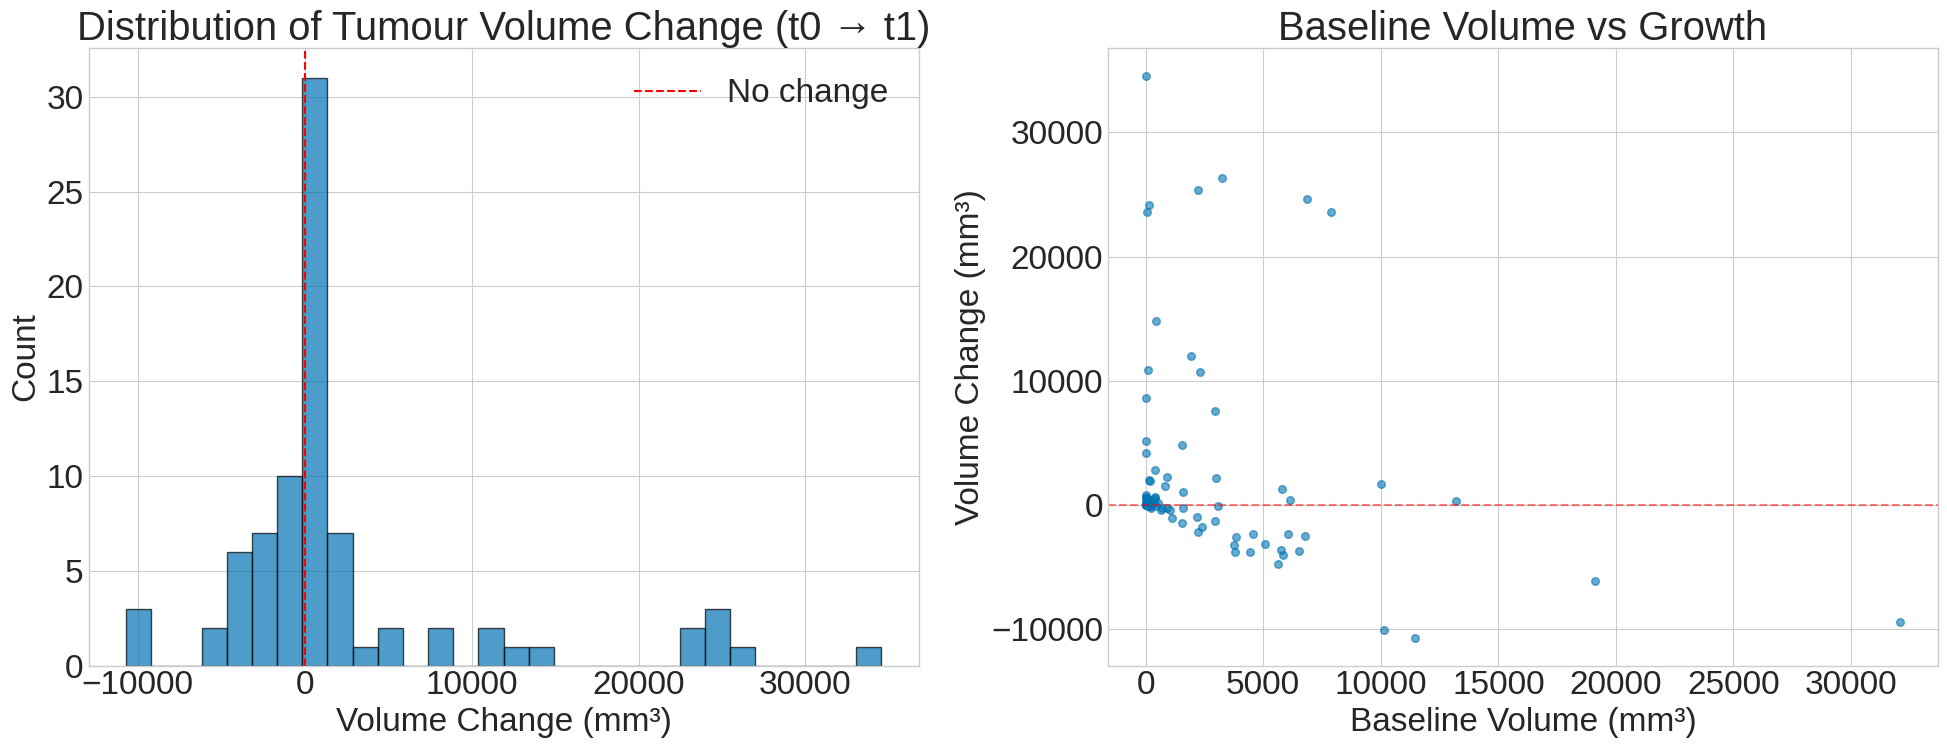

In [177]:
# Set global font size for plots
plt.rcParams.update({'font.size': 24})

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Histogram
axes[0].hist(growth_df[TARGET_COL], bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--', label='No change')
axes[0].set_xlabel('Volume Change (mm³)')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Tumour Volume Change (t0 → t1)')
axes[0].legend()

# Baseline volume vs change
axes[1].scatter(growth_df['vol_t0'], growth_df[TARGET_COL], alpha=0.6, s=30)
axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Baseline Volume (mm³)')
axes[1].set_ylabel('Volume Change (mm³)')
axes[1].set_title('Baseline Volume vs Growth')

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, '05_growth_target_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

## Merge Clinical and Imaging Features

We merge the first-timepoint imaging features with the clinical feature matrix. The clinical features come from the preprocessed `X` matrix (leakage features already removed in Notebook 02).

We align on Patient ID, keeping only patients present in both datasets.

In [153]:
# We need to align Patient IDs between clinical and growth data
# Check the ID format in both
print("Clinical data ID sample:", high_fill_df.index[:3].tolist() if high_fill_df.index.name else 'Index not named')
print("Growth data ID sample:", growth_df['Patient ID'].iloc[:3].tolist())

# Check if clinical data has patient IDs as index or column
clinical_id_cols = [col for col in high_fill_df.columns if 'patient' in col.lower() or 'id' in col.lower()]
print(f"\nPotential ID columns in clinical data: {clinical_id_cols}")
print(f"Index name: {high_fill_df.index.name}")

Clinical data ID sample: Index not named
Growth data ID sample: ['PatientID_0003', 'PatientID_0005', 'PatientID_0011']

Potential ID columns in clinical data: ['idh1 mutation', 'idh2 mutation']
Index name: None


In [154]:
# The preprocessed X matrix doesn't have Patient_ID (dropped during encoding).
# We need to get Patient IDs from the original clinical data.
# Load the original clinical CSV to get the ID mapping.

MU_GLIOMA_CLINICAL_DATA = os.path.join(GLIOMA_DIR, 'MU_Glioma_Post_ClinicalData_July2025.xlsx')
original_clinical = pd.read_excel(MU_GLIOMA_CLINICAL_DATA, sheet_name='MU Glioma Post')

# Check format
print("Original clinical ID sample:", original_clinical['Patient_ID'].iloc[:3].tolist())
print("Growth data ID sample:", growth_df['Patient ID'].iloc[:3].tolist())

# The original clinical df has same row order as high_fill_df/X
# Add Patient ID back to clinical features
clinical_for_merge = high_fill_df.copy()
clinical_for_merge['Patient_ID'] = original_clinical['Patient_ID'].values
clinical_for_merge = clinical_for_merge.set_index('Patient_ID')

clean_feature_cols = X.columns.tolist()
print(f"Clean clinical features: {len(clean_feature_cols)}")

Original clinical ID sample: ['PatientID_0003', 'PatientID_0004', 'PatientID_0005']
Growth data ID sample: ['PatientID_0003', 'PatientID_0005', 'PatientID_0011']
Clean clinical features: 28


In [155]:
# Build the combined feature matrix
# Start with growth_df (has Patient ID + imaging features + target)
# Add clinical features by matching Patient ID

imaging_feature_cols = [
    'vol_t0', 't0_t1c_mean', 't0_t1c_std',
    't0_t1n_mean', 't0_t1n_std', 't0_t2f_mean',
    't0_t2f_std', 't0_t2w_mean', 't0_t2w_std'
]

# Attempt merge using left_on and right_on for different column names
growth_with_clinical = growth_df.merge(
    clinical_for_merge[clean_feature_cols].reset_index(),
    left_on='Patient ID',
    right_on='Patient_ID',
    how='inner'
)

print(f"Merged dataset: {growth_with_clinical.shape}")
print(f"Patients retained: {len(growth_with_clinical)} / {len(growth_df)} (from growth data)")
print(f"Lost to ID mismatch: {len(growth_df) - len(growth_with_clinical)}")

Merged dataset: (74, 41)
Patients retained: 74 / 82 (from growth data)
Lost to ID mismatch: 8


In [156]:
# Define feature sets for comparison
all_feature_cols = clean_feature_cols + imaging_feature_cols

X_combined = growth_with_clinical[all_feature_cols].copy()
X_clinical_only = growth_with_clinical[clean_feature_cols].copy()
X_imaging_only = growth_with_clinical[imaging_feature_cols].copy()
y_growth = growth_with_clinical[TARGET_COL].copy()

print(f"Feature sets:")
print(f"  Clinical only: {X_clinical_only.shape[1]} features")
print(f"  Imaging only: {X_imaging_only.shape[1]} features")
print(f"  Combined: {X_combined.shape[1]} features")
print(f"  Target: {y_growth.shape[0]} samples")

Feature sets:
  Clinical only: 28 features
  Imaging only: 9 features
  Combined: 37 features
  Target: 74 samples


In [157]:
# Remove leakage features that encode future outcomes
# These were identified in Notebook 02 but may persist in the preprocessed data
leakage_features = [
    'second progression/recurrence',
    'type of 2nd progression',
    'time to first progression (days)',
    'number of days from diagnosis to date of first progression',
    'number of days from diagnosis to first surgery or procedure',
    'progression',
    'type of 1st progression'
]

if leakage_features:
    print(f"Removing {len(leakage_features)} leakage features:")
    for f in leakage_features:
        print(f"  - {f}")

    X_combined = X_combined.drop(columns=leakage_features)
    X_clinical_only = X_clinical_only.drop(columns=[f for f in leakage_features if f in X_clinical_only.columns])
    clean_feature_cols = [c for c in clean_feature_cols if c not in leakage_features]

    print(f"\nUpdated feature sets:")
    print(f"  Clinical only: {X_clinical_only.shape[1]} features")
    print(f"  Imaging only: {X_imaging_only.shape[1]} features")
    print(f"  Combined: {X_combined.shape[1]} features")
else:
    print("No leakage features found.")

Removing 7 leakage features:
  - second progression/recurrence
  - type of 2nd progression
  - time to first progression (days)
  - number of days from diagnosis to date of first progression
  - number of days from diagnosis to first surgery or procedure
  - progression
  - type of 1st progression

Updated feature sets:
  Clinical only: 21 features
  Imaging only: 9 features
  Combined: 30 features


## Handle Outliers

Growth rate data may contain extreme outliers (e.g. very large tumour resections appearing as massive negative changes). We inspect the distribution and clip or remove outliers if necessary.

In [158]:
# Check for extreme values
q01 = y_growth.quantile(0.01)
q99 = y_growth.quantile(0.99)
iqr = y_growth.quantile(0.75) - y_growth.quantile(0.25)
lower_fence = y_growth.quantile(0.25) - 3 * iqr
upper_fence = y_growth.quantile(0.75) + 3 * iqr

outliers = (y_growth < lower_fence) | (y_growth > upper_fence)
print(f"Outlier detection (3x IQR):")
print(f"  Lower fence: {lower_fence:.0f} mm³")
print(f"  Upper fence: {upper_fence:.0f} mm³")
print(f"  Outliers: {outliers.sum()} ({outliers.mean()*100:.1f}%)")

if outliers.sum() > 0:
    print(f"\nOutlier values:")
    print(y_growth[outliers].values)

Outlier detection (3x IQR):
  Lower fence: -9664 mm³
  Upper fence: 10970 mm³
  Outliers: 11 (14.9%)

Outlier values:
[ 11991 -10689  26363  24658  23623  34513 -10115  14818  25329  24146
  23561]


In [159]:
# Decision: clip extreme outliers rather than removing them to preserve sample size
# This is important given we already have a small dataset (~82 patients)
if outliers.sum() > 0:
    y_growth_clipped = y_growth.clip(lower=lower_fence, upper=upper_fence)
    print(f"Clipped {outliers.sum()} outliers to [{lower_fence:.0f}, {upper_fence:.0f}]")
else:
    y_growth_clipped = y_growth.copy()
    print("No outliers detected; using original values.")

Clipped 11 outliers to [-9664, 10970]


## Model Training and Evaluation

We train regression models to predict tumour volume change from baseline features. Given the small sample size (~82 patients), we use **Repeated K-Fold cross-validation** (5 folds, 5 repeats = 25 evaluations) to get robust performance estimates.

We compare:
1. **Linear Regression** (baseline)
2. **Ridge Regression** (L2 regularisation; better for small datasets with correlated features)
3. **XGBRegressor** (gradient boosted trees; consistent with our classification pipeline)

For each, we test three feature sets: clinical only, imaging only, and combined.

Metrics: R², MAE, RMSE.

In [160]:
def evaluate_regression(X, y, model, model_name, cv):
    """Run cross-validated regression and return summary metrics."""
    scoring = ['r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error']
    results = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=False)

    r2 = results['test_r2']
    mae = -results['test_neg_mean_absolute_error']
    rmse = -results['test_neg_root_mean_squared_error']

    return {
        'model': model_name,
        'R2_mean': r2.mean(), 'R2_std': r2.std(),
        'MAE_mean': mae.mean(), 'MAE_std': mae.std(),
        'RMSE_mean': rmse.mean(), 'RMSE_std': rmse.std(),
    }

In [161]:
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'XGBRegressor': XGBRegressor(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbosity=0
    ),
}

feature_sets = {
    'Clinical Only': X_clinical_only,
    'Imaging Only': X_imaging_only,
    'Combined': X_combined,
}

In [162]:
# Run all model-feature set combinations
all_results = []

for feat_name, X_feat in feature_sets.items():
    # One-hot encode categorical features for the current feature set
    # This is necessary because X.pkl still contains object type columns
    categorical_cols = X_feat.select_dtypes(include='object').columns
    if len(categorical_cols) > 0:
        X_encoded = pd.get_dummies(X_feat, columns=categorical_cols, drop_first=True)
    else:
        X_encoded = X_feat.copy()

    # Handle remaining missing values (for numerical features) by filling with median
    X_clean = X_encoded.fillna(X_encoded.median())

    # Ensure all column names are strings for XGBoost compatibility
    X_clean.columns = X_clean.columns.astype(str)

    for model_name, model in models.items():
        label = f"{model_name} ({feat_name})"
        print(f"Evaluating: {label}...")
        result = evaluate_regression(X_clean, y_growth_clipped, model, label, cv)
        result['feature_set'] = feat_name
        result['algorithm'] = model_name
        all_results.append(result)

results_df = pd.DataFrame(all_results)
print("\nDone.")

Evaluating: Linear Regression (Clinical Only)...
Evaluating: Ridge (Clinical Only)...
Evaluating: XGBRegressor (Clinical Only)...
Evaluating: Linear Regression (Imaging Only)...
Evaluating: Ridge (Imaging Only)...
Evaluating: XGBRegressor (Imaging Only)...
Evaluating: Linear Regression (Combined)...
Evaluating: Ridge (Combined)...
Evaluating: XGBRegressor (Combined)...

Done.


### Results Comparison

In [163]:
results_df.head()

,model,R2_mean,R2_std,MAE_mean,MAE_std,RMSE_mean,RMSE_std,feature_set,algorithm
0,Linear Regression (Clinical Only),-0.556365,0.796359,4477.741960,900.230348,5644.330330,1080.837007,Clinical Only,Linear Regression
1,Ridge (Clinical Only),-0.333275,0.558288,4227.842043,882.631004,5343.025402,977.040791,Clinical Only,Ridge
2,XGBRegressor (Clinical Only),-0.514087,0.637982,4395.370357,931.361435,5709.792589,1029.213809,Clinical Only,XGBRegressor
3,Linear Regression (Imaging Only),-0.140697,0.418669,3845.031190,688.471773,4995.051651,1072.685785,Imaging Only,Linear Regression
4,Ridge (Imaging Only),-0.140666,0.418621,3845.002336,688.451156,4994.992404,1072.604963,Imaging Only,Ridge


In [164]:
# Format results table
print("=" * 90)
print("GROWTH RATE PREDICTION RESULTS")
print("=" * 90)
print(f"{'Model':<35} {'R²':>12} {'MAE (mm³)':>14} {'RMSE (mm³)':>14}")
print("-" * 90)

for _, row in results_df.iterrows():
    r2_str = f"{row['R2_mean']:.3f} ± {row['R2_std']:.3f}"
    mae_str = f"{row['MAE_mean']:.0f} ± {row['MAE_std']:.0f}"
    rmse_str = f"{row['RMSE_mean']:.0f} ± {row['RMSE_std']:.0f}"
    print(f"{row['model']:<35} {r2_str:>12} {mae_str:>14} {rmse_str:>14}")

print("-" * 90)

GROWTH RATE PREDICTION RESULTS
Model                                         R²      MAE (mm³)     RMSE (mm³)
------------------------------------------------------------------------------------------
Linear Regression (Clinical Only)   -0.556 ± 0.796     4478 ± 900    5644 ± 1081
Ridge (Clinical Only)               -0.333 ± 0.558     4228 ± 883     5343 ± 977
XGBRegressor (Clinical Only)        -0.514 ± 0.638     4395 ± 931    5710 ± 1029
Linear Regression (Imaging Only)    -0.141 ± 0.419     3845 ± 688    4995 ± 1073
Ridge (Imaging Only)                -0.141 ± 0.419     3845 ± 688    4995 ± 1073
XGBRegressor (Imaging Only)         -0.179 ± 0.436     3940 ± 574     5008 ± 655
Linear Regression (Combined)        -3.675 ± 5.544    5993 ± 1287    8876 ± 3141
Ridge (Combined)                    -0.617 ± 0.905     4410 ± 927    5817 ± 1695
XGBRegressor (Combined)             -0.151 ± 0.411     3893 ± 389     4939 ± 560
----------------------------------------------------------------------

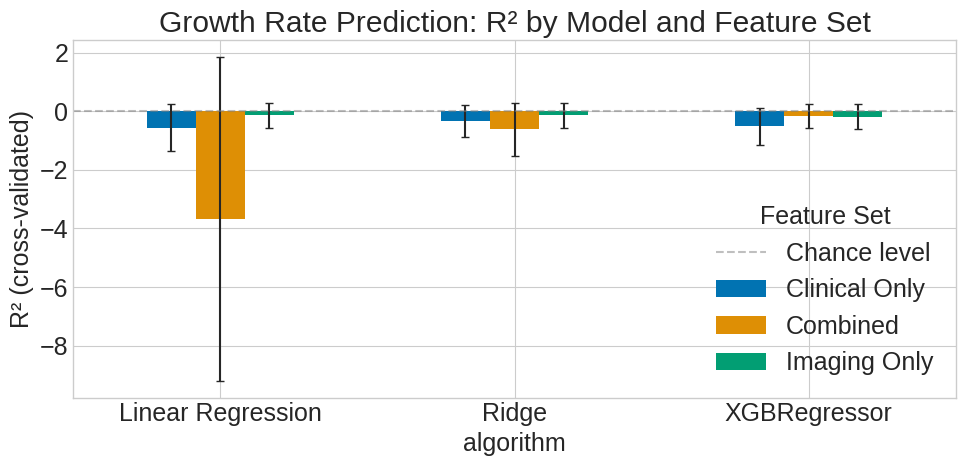

In [165]:
# Visualise: grouped bar chart of R² by model and feature set
fig, ax = plt.subplots(figsize=(10, 5))

pivot = results_df.pivot(index='algorithm', columns='feature_set', values='R2_mean')
pivot_err = results_df.pivot(index='algorithm', columns='feature_set', values='R2_std')

pivot.plot(kind='bar', yerr=pivot_err, ax=ax, capsize=3)
ax.set_ylabel('R² (cross-validated)')
ax.set_title('Growth Rate Prediction: R² by Model and Feature Set')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.axhline(y=0, color='grey', linestyle='--', alpha=0.5, label='Chance level')
ax.legend(title='Feature Set')

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, '05_growth_r2_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

## Feature Importance (Best Model)

We inspect which features drive the growth rate prediction in the best-performing model.

In [166]:
# Identify best model configuration
best_idx = results_df['R2_mean'].idxmax()
best_row = results_df.iloc[best_idx]
print(f"Best model: {best_row['model']}")
print(f"  R² = {best_row['R2_mean']:.3f} ± {best_row['R2_std']:.3f}")
print(f"  MAE = {best_row['MAE_mean']:.0f} ± {best_row['MAE_std']:.0f} mm³")

Best model: Ridge (Imaging Only)
  R² = -0.141 ± 0.419
  MAE = 3845 ± 688 mm³


In [167]:
# Train the best XGBRegressor on full data for feature importance
best_feat_set = best_row['feature_set']
X_best_raw = feature_sets[best_feat_set].copy()

# Apply the same preprocessing as in run_models
categorical_cols = X_best_raw.select_dtypes(include='object').columns
if len(categorical_cols) > 0:
    X_best_encoded = pd.get_dummies(X_best_raw, columns=categorical_cols, drop_first=True)
else:
    X_best_encoded = X_best_raw.copy()

# Handle remaining missing values (for numerical features) by filling with median
X_best = X_best_encoded.fillna(X_best_encoded.median())

# Ensure all column names are strings for XGBoost compatibility
X_best.columns = X_best.columns.astype(str)

xgb_final = XGBRegressor(
    n_estimators=100, max_depth=3, learning_rate=0.1,
    subsample=0.8, colsample_bytree=0.8, random_state=42, verbosity=0
)
xgb_final.fit(X_best, y_growth_clipped)

# Feature importance
importance = pd.Series(xgb_final.feature_importances_, index=X_best.columns)
importance = importance.sort_values(ascending=False)

print(f"\nTop 15 features for growth rate prediction ({best_feat_set}):")
print("-" * 70)
for feat, imp in importance.head(15).items():
    print(f"  {feat:<61} {imp:.4f}")


Top 15 features for growth rate prediction (Imaging Only):
----------------------------------------------------------------------
  t0_t2w_std                                                    0.2036
  vol_t0                                                        0.1650
  t0_t2w_mean                                                   0.1478
  t0_t1n_std                                                    0.1067
  t0_t1c_mean                                                   0.1044
  t0_t2f_std                                                    0.0763
  t0_t1c_std                                                    0.0752
  t0_t1n_mean                                                   0.0620
  t0_t2f_mean                                                   0.0590


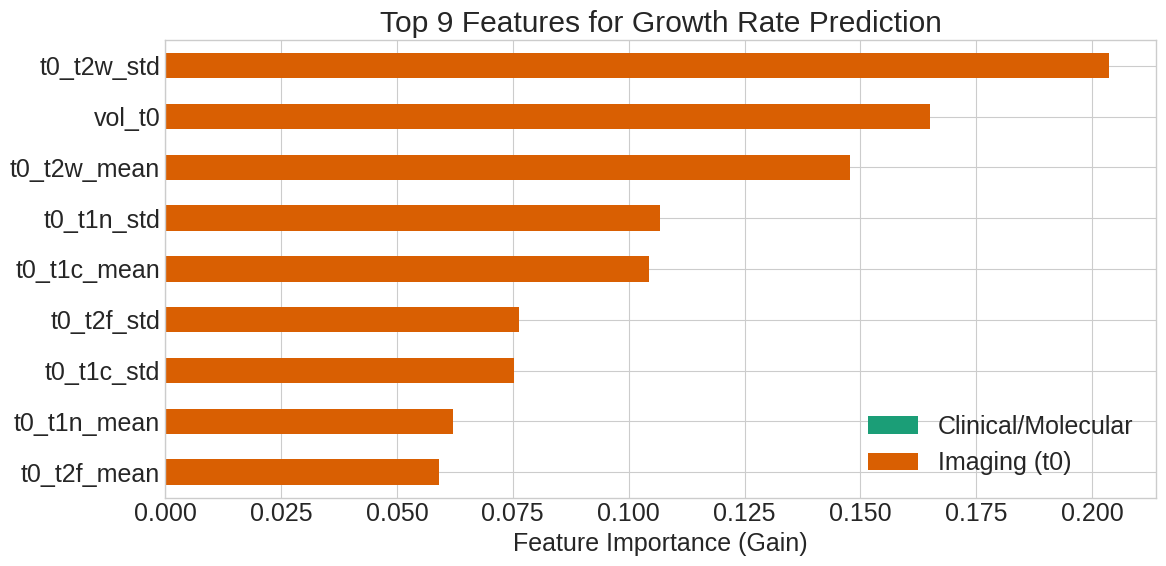

In [168]:
# Plot feature importance
fig, ax = plt.subplots(figsize=(12, 6))

top_n = min(15, len(importance))
top_feats = importance.head(top_n)

# Colour imaging vs clinical features differently
colours = ['#d95f02' if f in imaging_feature_cols else '#1b9e77' for f in top_feats.index]

top_feats.plot(kind='barh', ax=ax, color=colours)
ax.set_xlabel('Feature Importance (Gain)')
ax.set_title(f'Top {top_n} Features for Growth Rate Prediction')
ax.invert_yaxis()

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#1b9e77', label='Clinical/Molecular'),
    Patch(facecolor='#d95f02', label='Imaging (t0)')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, '05_growth_feature_importance.png'), dpi=150, bbox_inches='tight')
plt.show()

## Biological Validation: Growth Rate vs Survival

If our predicted growth rates are biologically meaningful, patients with faster-growing tumours should have worse survival outcomes. We stratify patients into growth tertiles and compare their survival status as a sanity check.

In [169]:
# Merge survival outcome with growth data
# The original 'y' series has numerical index, while growth_with_clinical has 'Patient ID'.
# We need to map Patient IDs from original_clinical to the 'death' values from y.
survival_lookup = pd.Series(y.values, index=original_clinical['Patient_ID']).to_dict()

growth_with_clinical['death'] = growth_with_clinical['Patient ID'].map(survival_lookup)

# Check alignment
print(f"Patients with survival data: {growth_with_clinical['death'].notna().sum()} / {len(growth_with_clinical)}")

Patients with survival data: 74 / 74


In [170]:
# Stratify into growth tertiles
growth_with_clinical['growth_tertile'] = pd.qcut(
    growth_with_clinical[TARGET_COL], q=3,
    labels=['Slow/Shrinking', 'Moderate', 'Fast Growing']
)

# Mortality rate per tertile
tertile_mortality = growth_with_clinical.groupby('growth_tertile')['death'].agg(['mean', 'count'])
tertile_mortality.columns = ['Mortality Rate', 'N']
print("Mortality Rate by Growth Tertile:")
print("-" * 45)
for idx, row in tertile_mortality.iterrows():
    print(f"  {idx:<20} {row['Mortality Rate']:.1%}  (n={row['N']:.0f})")

Mortality Rate by Growth Tertile:
---------------------------------------------
  Slow/Shrinking       76.0%  (n=25)
  Moderate             62.5%  (n=24)
  Fast Growing         64.0%  (n=25)


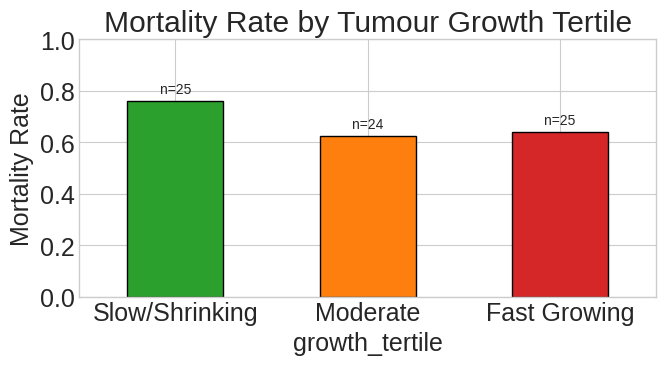


Chi-squared test: χ² = 1.24, p = 0.5386
No significant association detected (may be underpowered with small n).


In [171]:
# Visualise
fig, ax = plt.subplots(figsize=(7, 4))

tertile_mortality['Mortality Rate'].plot(
    kind='bar', ax=ax, color=['#2ca02c', '#ff7f0e', '#d62728'], edgecolor='black'
)
ax.set_ylabel('Mortality Rate')
ax.set_title('Mortality Rate by Tumour Growth Tertile')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_ylim(0, 1)

# Add count labels
for i, (idx, row) in enumerate(tertile_mortality.iterrows()):
    ax.text(i, row['Mortality Rate'] + 0.03, f"n={row['N']:.0f}",
            ha='center', fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, '05_growth_vs_mortality.png'), dpi=150, bbox_inches='tight')
plt.show()

# Chi-squared test
contingency = pd.crosstab(growth_with_clinical['growth_tertile'], growth_with_clinical['death'])
chi2, p_val, dof, expected = stats.chi2_contingency(contingency)
print(f"\nChi-squared test: χ² = {chi2:.2f}, p = {p_val:.4f}")
if p_val < 0.05:
    print("Significant association between growth tertile and mortality.")
else:
    print("No significant association detected (may be underpowered with small n).")

## Save Results

In [172]:
# Save results table
results_df.to_csv(os.path.join(results_dir, '05_growth_rate_model_comparison.csv'), index=False)

# Save feature importance
importance.to_csv(os.path.join(results_dir, '05_growth_rate_feature_importance.csv'))

# Save the growth data for potential reuse
growth_with_clinical.to_csv(os.path.join(results_dir, '05_growth_data_with_features.csv'), index=False)

print(f"Results saved to {results_dir}")
print(f"Figures saved to {figures_dir}")

Results saved to drive/MyDrive/Y3 Project/Data/PKG_MU_Glioma_Post/results/growth_rate
Figures saved to drive/MyDrive/Y3 Project/Data/PKG_MU_Glioma_Post/results/figures/growth_rate


## Summary

This notebook addressed Aim 2 by predicting tumour volume change between consecutive MRI scans using baseline features.

**Key findings** (to be filled after running):
- Best model and feature set: ...
- R² score: ... (compare to 0 baseline; R² > 0 means better than predicting the mean)
- Whether imaging features from the first timepoint add predictive value beyond clinical/molecular markers
- Whether predicted growth rate correlates with actual survival outcomes (biological validation)

**Limitations:**
- Small sample size (~82 patients with 2+ timepoints); results may have high variance
- Volume change used as proxy for growth rate (exact scan dates not available in the segmentation file)
- Pre-computed imaging features are first-order statistics only; texture and shape features (via PyRadiomics) could potentially add value
- Temporal leakage risk is low here since we predict future volume change from baseline features, but growth may correlate with follow-up duration